In [79]:
%run init_notebook.py

In [104]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt

In [105]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [107]:
# Load data
model_type = "lgb"
data_len = 1560
is_sent = False
predicted = "sp_close_lead2"

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [108]:
# predict# predicted is y col
data_dict["model_features"].update(predicted=predicted)

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# Model features

In [109]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     # 'ff_M_RF',
     # 'ff_SMB',
     # 'ff_HML',
     # 'ff_RMW',
     # 'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
]

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [110]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# Cross corr

In [111]:
df_cross_corr(df_ws,
              # cols,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]],
              data_dict["model_features"]["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[]

In [112]:
# df_ws, _ = shift_var_relative_to_df(df_ws,
#                                  shift_var=["ff_SMB"],
#                                  no_lags=[4])
# data_dict["data_transformation"].update(shift_var=_)
# df_ws = df_ws.dropna()

# Multi corr

,VIF,corr_sp_close_lead2
sp_close_lag3,3.632023,-0.100745
sp_close_lag4,4.220434,-0.077281
sp_close_lag7,2.981429,-0.029759
sp_close_lag5,4.629823,-0.009607
sp_close_lag6,4.779165,0.004160
sp_close_lag2,4.466278,0.093214
sp_close_lag1,5.034795,0.286220
sp_close,2.962895,0.510461


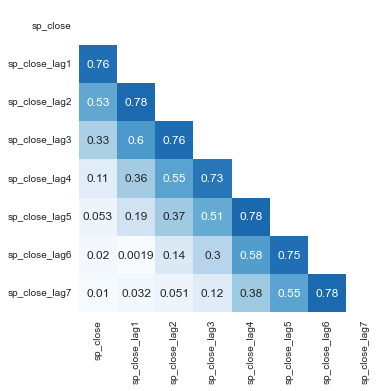

In [113]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["model_features"]["predicted"])

# tts & standard scaling

In [114]:
df_train = df_ws.copy()

In [115]:
X_train, X_test, y_train, y_test = tts_data(df_train, 
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            add_const=False,
                                            random_split=False,
                                            test_size=.2)

In [93]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

In [94]:
data_dict["data_transformation"].update(standard_scaling={"scaled_cols": data_dict["model_features"]["predictor"],
                                                          "scaler_x": scaler_x})

# Tuner

In [95]:
tuner_params = {
    'objective': 'regression',
    'metric': ['log_loss', 'l2'],
    'random_state': random_state
}

tuner_train = lightgbm.Dataset(X_train, y_train)
tuner_eval = lightgbm.Dataset(X_test, y_test, reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 20

In [96]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)]
                               )
tuner.run()
t_end = dt.datetime.now()

[I 2022-03-14 15:38:08,229] A new study created in memory with name: no-name-859d054f-c645-455f-9fa3-7ea3bdf5998e
[I 2022-03-14 15:38:10,491] Trial 0 finished with value: 0.00023606616979691812 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.00023606616979691812.
[I 2022-03-14 15:38:12,511] Trial 1 finished with value: 0.00023606616979691812 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.00023606616979691812.
[I 2022-03-14 15:38:14,528] Trial 2 finished with value: 0.0002307927142277981 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.0002307927142277981.
[I 2022-03-14 15:38:16,517] Trial 3 finished with value: 0.00022910959716810944 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.00022910959716810944.
[I 2022-03-14 15:38:18,491] Trial 4 finished with value: 0.00022910959716810944 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.00022910959716810944

In [97]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

Parameters where tuned for 0:01:29.479260
Max training time was 1200


In [98]:
# params = {'objective': 'regression',
#  'metric': ['log_loss', 'l2'],
#  'random_state': 101,
#  'feature_pre_filter': False,
#  'lambda_l1': 0.0,
#  'lambda_l2': 0.0,
#  'num_leaves': 31,
#  'feature_fraction': 1.0,
#  'bagging_fraction': 0.6654319485899407,
#  'bagging_freq': 2,
#  'min_child_samples': 20}

In [99]:
params = tuner.best_params

# Model

In [100]:
lgb_train = lightgbm.Dataset(X_train, y_train)
lgb_test = lightgbm.Dataset(X_test, y_test, reference=lgb_train)
evals_result = {} 

In [101]:
%%capture
model = lightgbm.train(params,
                           lgb_train,
                           num_boost_round=1000,
                           valid_sets=[lgb_test, lgb_train],
                           callbacks=[lightgbm.early_stopping(100000), lightgbm.record_evaluation(evals_result)])
data_dict["model_features"].update(params=params)

# Model eval

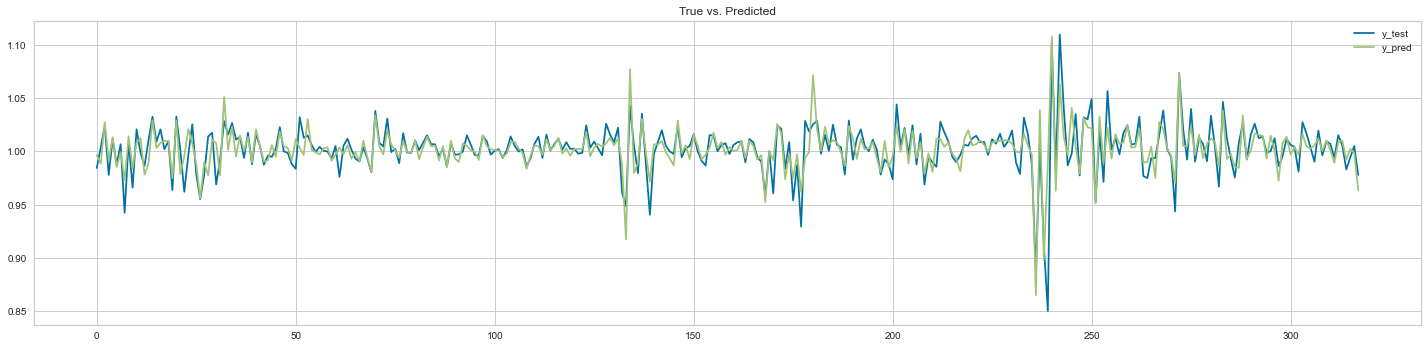

Validation Scores
mean squared error: 0.0002237857
mean absolute error: 0.0096829664
R2: 0.6072416511


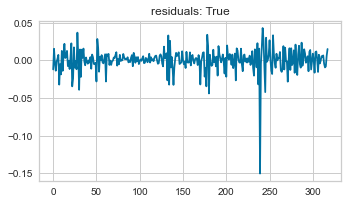

Stationarity Test Results
P-Values: 8.354875126131639e-09
Test-stats: -6.561593234402306
Time series is stationary: True


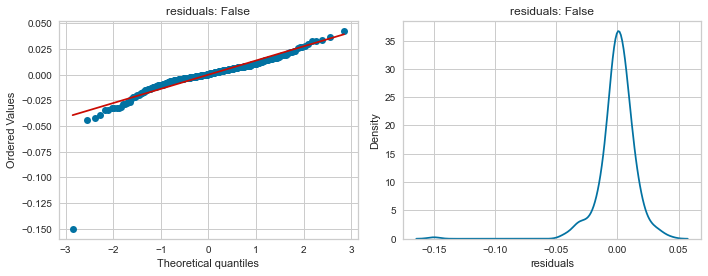

Normality Test Results
P-Values: 2.4628404586597738e-59
Test-stats: 269.902410289635
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


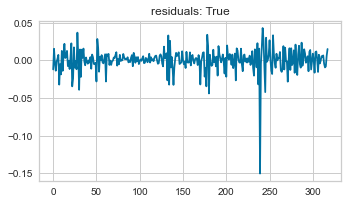

Test for Heteroskedasticity
Test p-value: 3.0574731193944046e-41
Heteroskedasticity is present: True


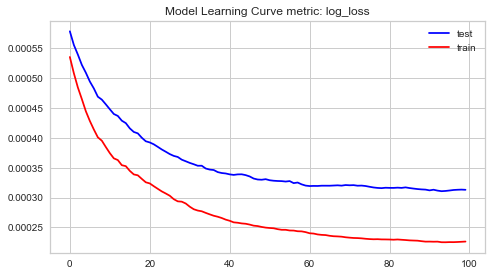

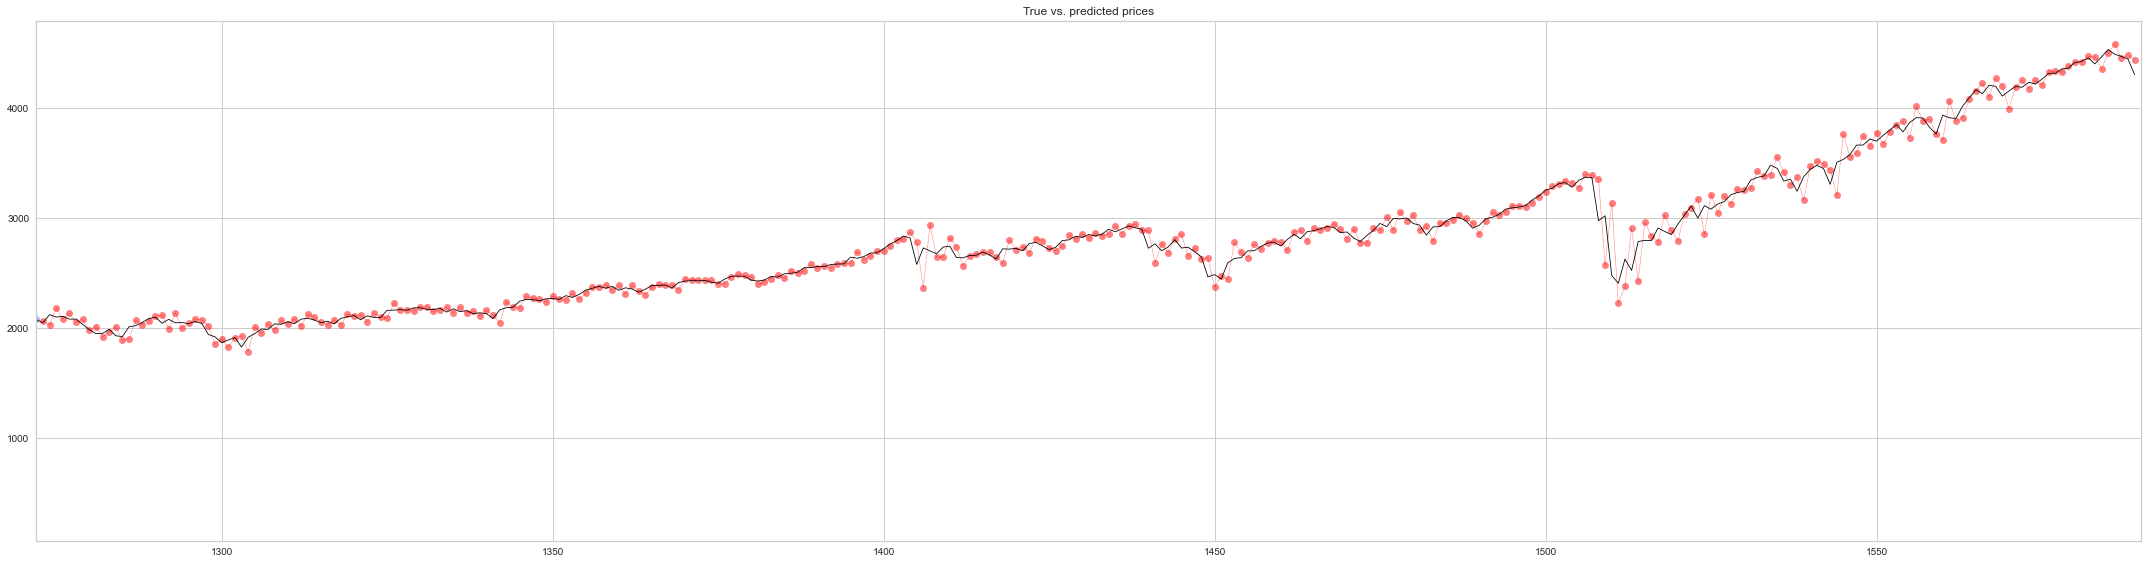

Validation Scores Test Data
mean squared error: 8828.0861023159
mean absolute error: 58.9956938434
mean absolute error in %: 0.04201206915608294
r2: 0.9796421854


In [102]:
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=model,
                          print_results=True)

fig_truefit = lgb_eval.get_model_performance()
stat, norm, hetero = lgb_eval.analyse_resids()
fig_lcurve = lgb_eval.lgbm_learning_curve(params, lgb_train, lgb_test, "Model Learning Curve", n_splits=10)
fig_prices = lgb_eval.plot_results_on_price_scale(df_w,
                                 df_ws,
                                 sp_true_vals=data_dict["data"]["sp_true_vals"],
                                 show_pred_only=True)

#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=lgb_eval.mse)
data_dict["model_metrics"].update(mae=lgb_eval.mae)
data_dict["model_metrics"].update(r2=lgb_eval.r2)
data_dict["model_metrics"].update(residuals=lgb_eval.resid_inv)

# Save model

In [103]:
save_model(model, df_train, data_dict, fig_truefit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-14_lgb_1560_sp_close_lead1_sentFalse"? (y/n)


 y
